### Imports & Logging Setup

In [22]:
# Import necessary libraries
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Dataset

In [23]:
# Load the miRNA dataset
file_path = "../processed_data/miRNA_stage_subtype.csv"  # Adjust path if needed
miRNA_df = pd.read_csv(file_path)

# Check dataset structure
print("Dataset Shape:", miRNA_df.shape)
print("Columns:", miRNA_df.columns)

# Create a binary diagnosis column (0 = Healthy, 1 = Cancer)
miRNA_df["diagnosis"] = miRNA_df["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Verify if the column was created
print("Updated Dataset Columns:\n", miRNA_df.columns)


Dataset Shape: (1091, 1883)
Columns: Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-943', 'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500',
       'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a', 'hsa-mir-99b', 'stage',
       'subtype'],
      dtype='object', length=1883)
Updated Dataset Columns:
 Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500', 'hsa-mir-96', 'hsa-mir-98',
       'hsa-mir-99a', 'hsa-mir-99b', 'stage', 'subtype', 'diagnosis'],
      dtype='object', length=1884)


### Feature Selection & Labels

In [25]:
import os
import pandas as pd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths (Ensure these are correct)
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load features safely (From SVM script)
def load_all_features(file_paths, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue  # Skip processed data file

        if os.path.exists(path):
            df = pd.read_csv(path)
            if key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    # Merge selected features (remove duplicates)
    combined_features = set().union(*feature_sets.values())
    logging.info(f"Total unique features selected: {len(combined_features)}")

    return list(combined_features)

### Code (Feature Scaling & Train-Test Split)

In [30]:
# Ensure we are only using the 38 selected features
num_features_to_select = 38  # Match SVM's feature selection

# Reload selected features in case it's not available
selected_features = load_all_features(file_paths, num_features=num_features_to_select)

# Remove 'subtype' and 'stage' if they somehow got included
selected_features = [f for f in selected_features if f in miRNA_df.columns and f not in ["subtype", "stage"]]

# STRICTLY LIMIT TO THE FIRST 38 FEATURES (if more were selected)
selected_features = selected_features[:38]  # Ensures we only take the first 38

# Debugging: Print selected features to confirm
print("Final Selected Features for RF (Should Be 38):\n", selected_features)
print("Total Features Selected:", len(selected_features))  # Should print 38

# Standardize features for consistency with SVM
scaler = StandardScaler()

# Keep only the selected features before scaling
X_selected = miRNA_df[selected_features]  # Now guaranteed to contain only 38 features
X_scaled = scaler.fit_transform(X_selected)  

# Fix: Merge rare subtype (Subtype 4 → Subtype 2)
y_subtype = y_subtype.apply(lambda x: 2 if x == 4 else x)  # Merging subtype 4 into subtype 2

# Check updated class distribution
print("Updated Subtype Class Distribution After Merging:\n", y_subtype.value_counts())

# Train-test split (80-20, stratified) - Avoid overwriting X_train and X_test
X_train_diagnosis, X_test_diagnosis, y_diagnosis_train, y_diagnosis_test = train_test_split(
    X_scaled, y_diagnosis, test_size=0.2, random_state=42, stratify=y_diagnosis
)
X_train_stage, X_test_stage, y_stage_train, y_stage_test = train_test_split(
    X_scaled, y_stage, test_size=0.2, random_state=42, stratify=y_stage
)
X_train_subtype, X_test_subtype, y_subtype_train, y_subtype_test = train_test_split(
    X_scaled, y_subtype, test_size=0.2, random_state=42, stratify=y_subtype
)

# Check dataset split
print("Diagnosis Training Set Shape:", X_train_diagnosis.shape)
print("Stage Training Set Shape:", X_train_stage.shape)
print("Subtype Training Set Shape:", X_train_subtype.shape)

print("Diagnosis Testing Set Shape:", X_test_diagnosis.shape)
print("Stage Testing Set Shape:", X_test_stage.shape)
print("Subtype Testing Set Shape:", X_test_subtype.shape)

2025-02-27 22:39:22,581 - INFO - Total unique features selected: 142


Final Selected Features for RF (Should Be 38):
 ['hsa-mir-1972-1', 'hsa-mir-1283-2', 'hsa-mir-524', 'hsa-mir-6090', 'hsa-mir-1299', 'hsa-mir-203b', 'hsa-mir-448', 'hsa-mir-1282', 'hsa-mir-3661', 'hsa-mir-6720', 'hsa-mir-520a', 'hsa-mir-1303', 'hsa-mir-519d', 'hsa-mir-451b', 'hsa-mir-3927', 'hsa-mir-4508', 'hsa-mir-4460', 'hsa-mir-647', 'hsa-mir-4471', 'hsa-mir-4487', 'hsa-mir-3125', 'hsa-mir-548ak', 'hsa-mir-3622b', 'hsa-mir-3907', 'hsa-mir-936', 'hsa-mir-4450', 'hsa-mir-520e', 'hsa-mir-4302', 'hsa-mir-5694', 'hsa-mir-548ac', 'hsa-mir-603', 'hsa-mir-519e', 'hsa-mir-3145', 'hsa-mir-1253', 'hsa-mir-760', 'hsa-mir-520h', 'hsa-mir-518d', 'hsa-mir-6766']
Total Features Selected: 38
Updated Subtype Class Distribution After Merging:
 subtype
1    560
2    520
0     11
Name: count, dtype: int64
Diagnosis Training Set Shape: (872, 38)
Stage Training Set Shape: (872, 38)
Subtype Training Set Shape: (872, 38)
Diagnosis Testing Set Shape: (219, 38)
Stage Testing Set Shape: (219, 38)
Subtype Testin

### Define Hyperparameter Grid for Random Forest

In [31]:
# Define hyperparameter grid for tuning
param_grid = {
    "n_estimators": [100, 500, 1000],  # Number of trees in the forest
    "max_depth": [10, 50, None],  # Max depth of each tree (None = full growth)
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required at each leaf node
}

# Confirm that the grid is set up
print("Hyperparameter grid defined for GridSearchCV.")

Hyperparameter grid defined for GridSearchCV.


### Train & Evaluate Random Forest Models

In [50]:
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Function to train and evaluate Random Forest
def train_evaluate_rf(X_train, X_test, y_train, y_test, task_name):
    """
    Train a Random Forest classifier and evaluate performance.

    Parameters:
        X_train (array): Training features
        X_test (array): Testing features
        y_train (array): Training labels
        y_test (array): Testing labels
        task_name (str): Name of the classification task

    Returns:
        dict: Evaluation metrics and confusion matrix
    """
    logging.info(f"Training Random Forest for {task_name} classification...")

    # Initialize Random Forest classifier
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get best model from grid search
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    logging.info(f"Best Hyperparameters for {task_name}: {grid_search.best_params_}")
    logging.info(f"Accuracy for {task_name}: {accuracy:.4f}")

    return {
        "accuracy": accuracy,
        "classification_report": classification_rep,
        "confusion_matrix": cm,
        "best_model": best_rf,
    }

# Train and evaluate RF models for Diagnosis, Stage, and Subtype classification
metrics_diagnosis = train_evaluate_rf(X_train_diagnosis, X_test_diagnosis, y_diagnosis_train, y_diagnosis_test, "Diagnosis")
metrics_stage = train_evaluate_rf(X_train_stage, X_test_stage, y_stage_train, y_stage_test, "Stage")
metrics_subtype = train_evaluate_rf(X_train_subtype, X_test_subtype, y_subtype_train, y_subtype_test, "Subtype")

# Display accuracy results
print("\nDiagnosis Accuracy:", metrics_diagnosis["accuracy"])
print("Stage Accuracy:", metrics_stage["accuracy"])
print("Subtype Accuracy:", metrics_subtype["accuracy"])

2025-02-27 23:19:30,515 - INFO - Training Random Forest for Diagnosis classification...
2025-02-27 23:20:25,085 - INFO - Best Hyperparameters for Diagnosis: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
2025-02-27 23:20:25,086 - INFO - Accuracy for Diagnosis: 0.9909
2025-02-27 23:20:25,088 - INFO - Training Random Forest for Stage classification...
2025-02-27 23:21:35,936 - INFO - Best Hyperparameters for Stage: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
2025-02-27 23:21:35,937 - INFO - Accuracy for Stage: 0.5114
2025-02-27 23:21:35,941 - INFO - Training Random Forest for Subtype classification...
2025-02-27 23:22:43,737 - INFO - Best Hyperparameters for Subtype: {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
2025-02-27 23:22:43,738 - INFO - Accuracy for Subtype: 0.5434



Diagnosis Accuracy: 0.9908675799086758
Stage Accuracy: 0.5114155251141552
Subtype Accuracy: 0.54337899543379


### Compute Sensitivity, Specificity, and Confusion Matrices


-------------------- RF_Diagnosis Results --------------------
Accuracy: 0.9909
Sensitivity (Recall): 1.0000
Specificity: 0.0000

Confusion Matrix:
 [[  0   2]
 [  0 217]]


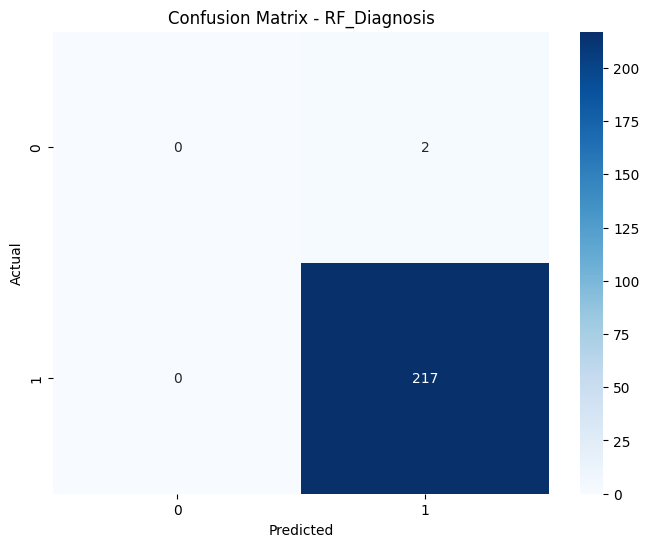


-------------------- RF_Stage Results --------------------
Accuracy: 0.5114
Sensitivity (Recall): 0.2078
Specificity: 0.3822

Confusion Matrix:
 [[  0   2   0   0   0]
 [  0 106   7   1   0]
 [  0  56   5   1   0]
 [  0  30   4   1   0]
 [  0   4   2   0   0]]


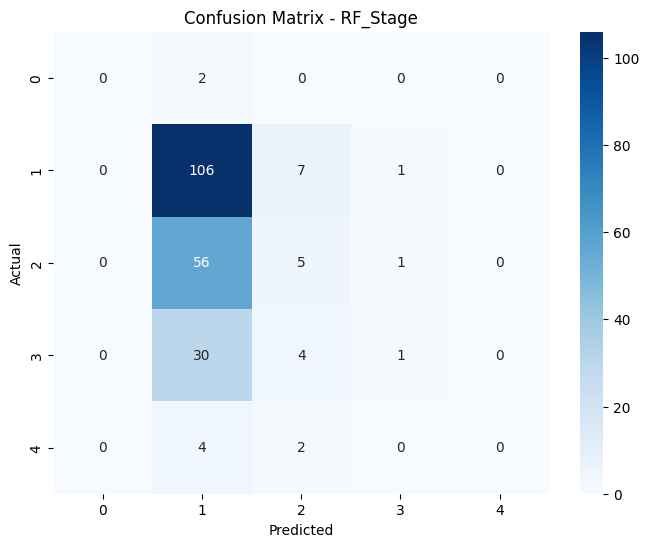


-------------------- RF_Subtype Results --------------------
Accuracy: 0.5434
Sensitivity (Recall): 0.3643
Specificity: 0.5418

Confusion Matrix:
 [[ 0  1  1]
 [ 0 67 46]
 [ 0 52 52]]


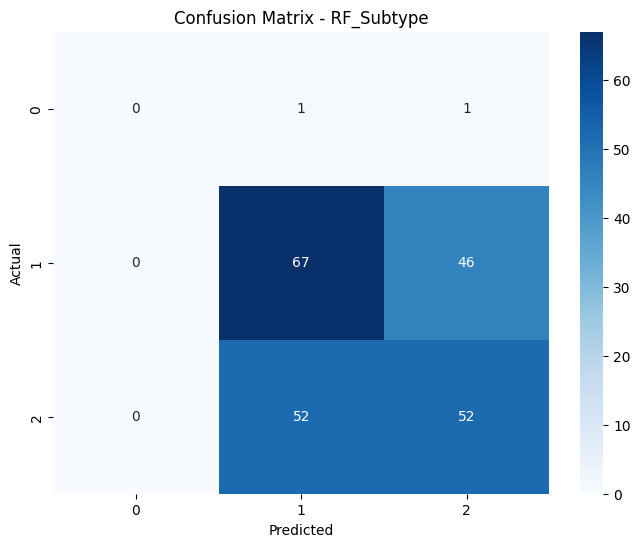

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Function to compute sensitivity, specificity, and confusion matrix
def evaluate_model(y_test, y_pred, model_name):
    """
    Evaluate model performance with accuracy, sensitivity, specificity, and confusion matrices.
    
    Args:
        y_test (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model being evaluated.

    Returns:
        dict: Contains accuracy, sensitivity, specificity, and confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute sensitivity (recall) & specificity
    if cm.shape == (2, 2):  # Binary classification case
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 1  # Set specificity to 1 if FP+TN=0
    else:  # Multiclass case
        sensitivity_values = np.diag(cm) / np.sum(cm, axis=1, where=np.sum(cm, axis=1) != 0)
        specificity_values = np.diag(cm) / np.sum(cm, axis=0, where=np.sum(cm, axis=0) != 0)

        sensitivity = np.nanmean(sensitivity_values)  # Average, ignoring NaN
        specificity = np.nanmean(specificity_values) if np.sum(cm) > 0 else 1  # Avoid NaN

    # Print evaluation results
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
    }

# ✅ Use the Correct X_test and y_test for Each Classification Task
metrics_diagnosis.update(evaluate_model(y_diagnosis_test, metrics_diagnosis["best_model"].predict(X_test_diagnosis), "RF_Diagnosis"))
metrics_stage.update(evaluate_model(y_stage_test, metrics_stage["best_model"].predict(X_test_stage), "RF_Stage"))
metrics_subtype.update(evaluate_model(y_subtype_test, metrics_subtype["best_model"].predict(X_test_subtype), "RF_Subtype"))

### Feature Importance, Correlation, and Covariance Matrices


Top 10 Important Features for RF_Diagnosis:
 ['hsa-mir-6720', 'hsa-mir-203b', 'hsa-mir-760', 'hsa-mir-520a', 'hsa-mir-3145', 'hsa-mir-4487', 'hsa-mir-6766', 'hsa-mir-5694', 'hsa-mir-3661', 'hsa-mir-3927']


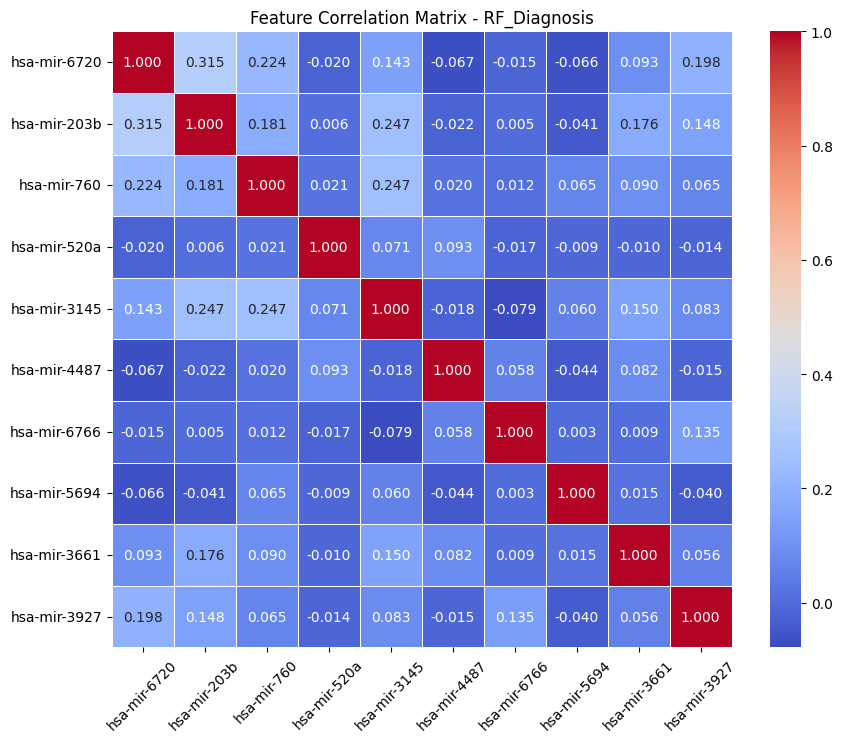

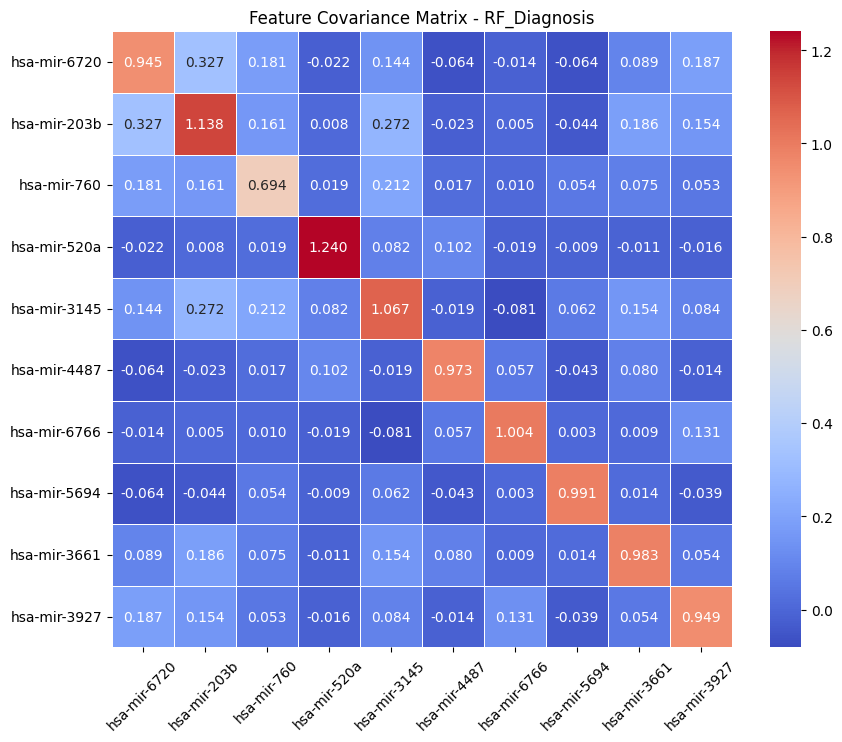


Top 10 Important Features for RF_Stage:
 ['hsa-mir-203b', 'hsa-mir-6720', 'hsa-mir-760', 'hsa-mir-520a', 'hsa-mir-3145', 'hsa-mir-4487', 'hsa-mir-3927', 'hsa-mir-6766', 'hsa-mir-5694', 'hsa-mir-1283-2']


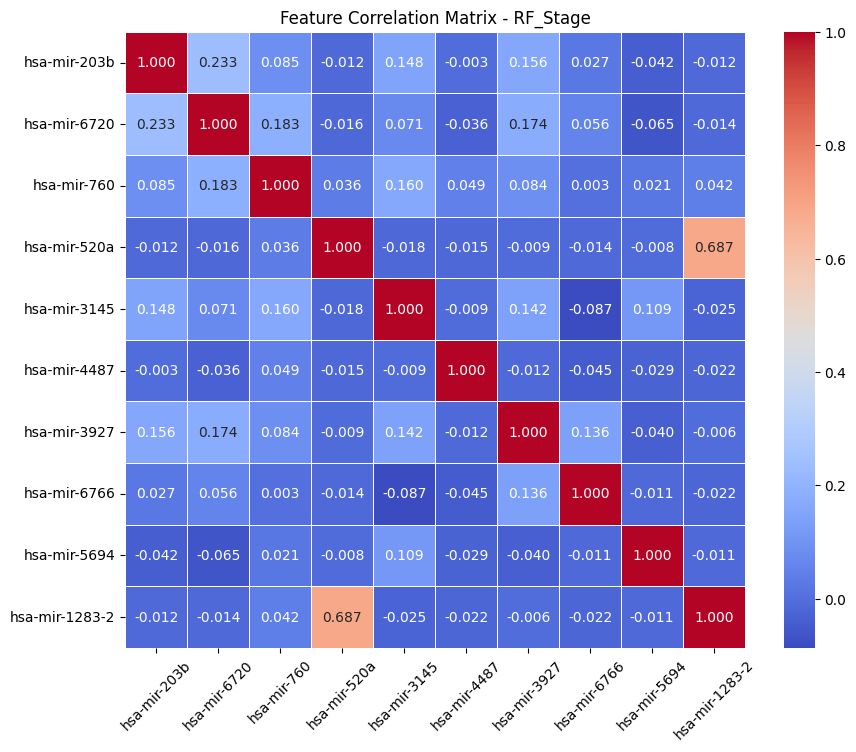

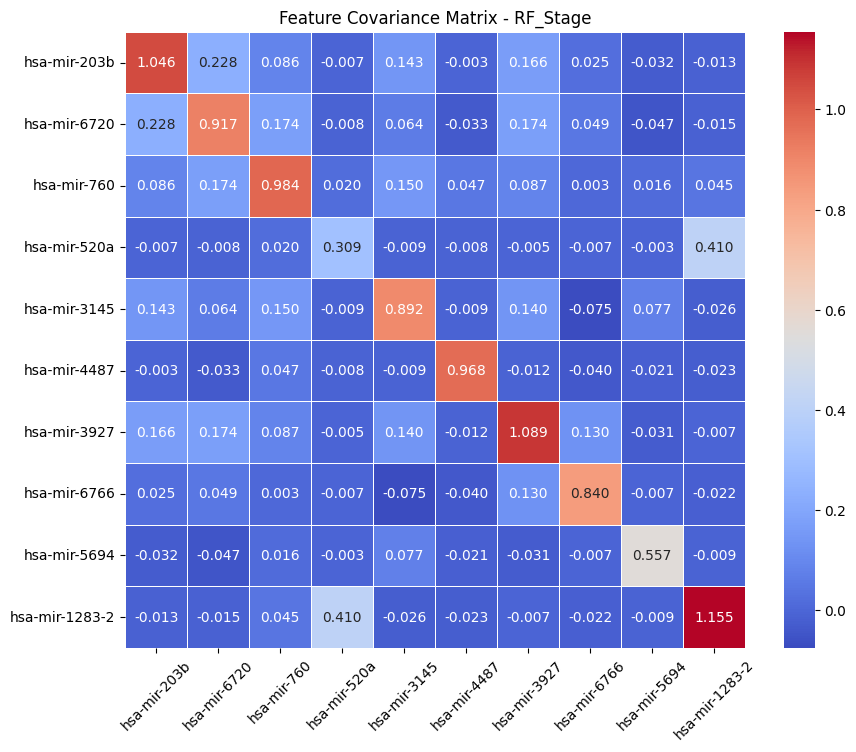


Top 10 Important Features for RF_Subtype:
 ['hsa-mir-6720', 'hsa-mir-203b', 'hsa-mir-760', 'hsa-mir-520a', 'hsa-mir-3145', 'hsa-mir-4487', 'hsa-mir-5694', 'hsa-mir-6766', 'hsa-mir-3927', 'hsa-mir-1282']


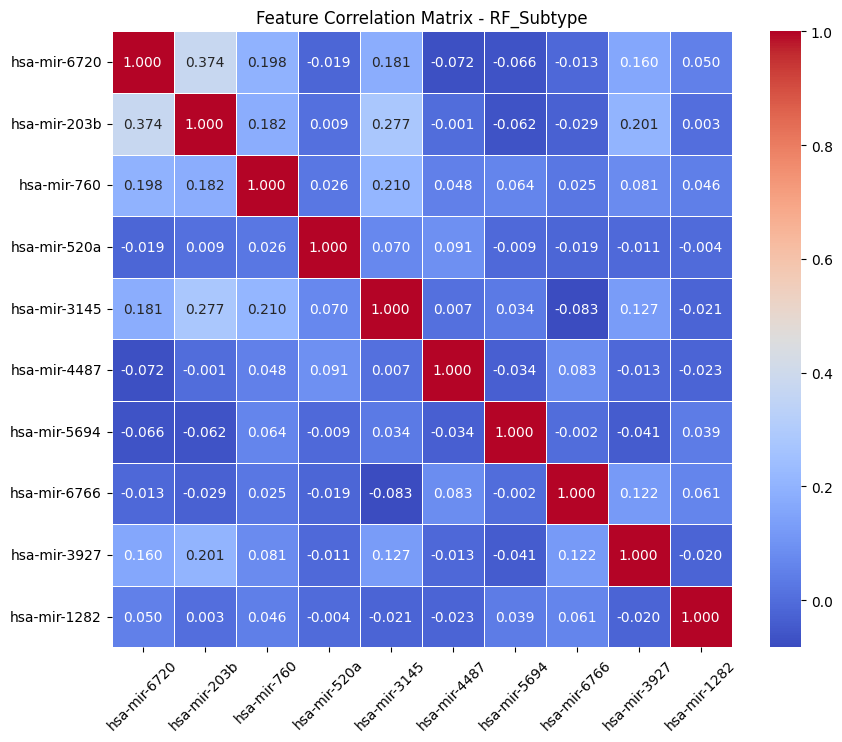

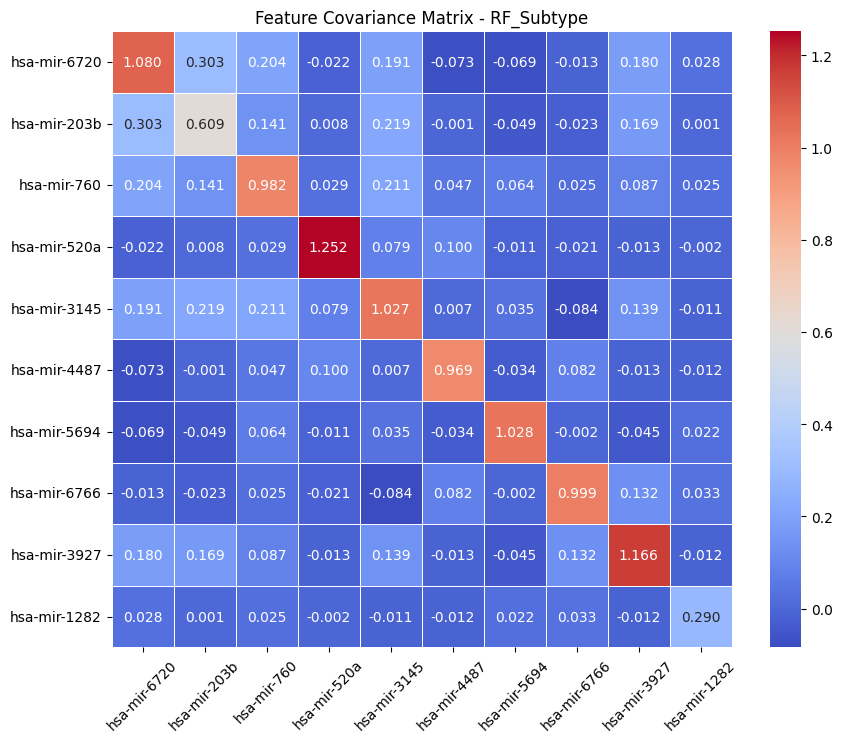

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Function to compute and plot correlation and covariance matrices
def feature_importance_analysis(model, X_train, selected_features, model_name):
    """
    Extracts top 10 features from Random Forest, computes correlation and covariance matrices,
    and generates plots.

    Args:
        model (RandomForestClassifier): Trained RF model.
        X_train (DataFrame): Training feature set.
        selected_features (list): List of selected features used in training.
        model_name (str): Name of the classification task.

    Returns:
        dict: Dictionary containing top 10 features, correlation matrix, and covariance matrix.
    """
    # Convert X_train to DataFrame with correct feature names
    X_train_df = pd.DataFrame(X_train, columns=selected_features)

    # Extract feature importances
    feature_importances = pd.Series(model.feature_importances_, index=selected_features)
    top_10_features = feature_importances.nlargest(10).index.tolist()

    print(f"\nTop 10 Important Features for {model_name}:\n", top_10_features)

    # Compute correlation matrix
    corr_matrix = X_train_df[top_10_features].corr()

    # Compute covariance matrix
    cov_matrix = X_train_df[top_10_features].cov()

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Correlation Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    # Plot covariance matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
    plt.title(f"Feature Covariance Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

    return {
        "top_10_features": top_10_features,
        "correlation_matrix": corr_matrix,
        "covariance_matrix": cov_matrix,
    }

# Use the Correct `X_train` and `selected_features` for Each Task
feature_analysis_diagnosis = feature_importance_analysis(
    metrics_diagnosis["best_model"], X_train_diagnosis, selected_features, "RF_Diagnosis"
)
feature_analysis_stage = feature_importance_analysis(
    metrics_stage["best_model"], X_train_stage, selected_features, "RF_Stage"
)
feature_analysis_subtype = feature_importance_analysis(
    metrics_subtype["best_model"], X_train_subtype, selected_features, "RF_Subtype"
)

### Saving All Results & Models

In [54]:
import os
import json
import joblib
import pandas as pd

# Define output directory
output_dir = "../results/random_forest/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Save trained models
joblib.dump(metrics_diagnosis["best_model"], os.path.join(output_dir, "rf_model_diagnosis.pkl"))
joblib.dump(metrics_stage["best_model"], os.path.join(output_dir, "rf_model_stage.pkl"))
joblib.dump(metrics_subtype["best_model"], os.path.join(output_dir, "rf_model_subtype.pkl"))

print("Random Forest models saved successfully.")

# Save predictions & actual labels with the correct test data
predictions = {
    "Diagnosis": (y_diagnosis_test, metrics_diagnosis["best_model"].predict(X_test_diagnosis), "rf_predictions_diagnosis.csv"),
    "Stage": (y_stage_test, metrics_stage["best_model"].predict(X_test_stage), "rf_predictions_stage.csv"),
    "Subtype": (y_subtype_test, metrics_subtype["best_model"].predict(X_test_subtype), "rf_predictions_subtype.csv"),
}

for label, (y_test, y_pred, filename) in predictions.items():
    pred_path = os.path.join(output_dir, filename)
    pd.DataFrame({"actual": y_test, "predicted": y_pred}).to_csv(pred_path, index=False)
    print(f"{label} predictions saved to {pred_path}")

# Save metadata (hyperparameters, accuracy, sensitivity, specificity)
metadata = {
    "diagnosis_hyperparameters": metrics_diagnosis["classification_report"],
    "stage_hyperparameters": metrics_stage["classification_report"],
    "subtype_hyperparameters": metrics_subtype["classification_report"],
    "diagnosis_accuracy": metrics_diagnosis["accuracy"],
    "stage_accuracy": metrics_stage["accuracy"],
    "subtype_accuracy": metrics_subtype["accuracy"],
    "diagnosis_sensitivity": metrics_diagnosis["sensitivity"],
    "stage_sensitivity": metrics_stage["sensitivity"],
    "subtype_sensitivity": metrics_subtype["sensitivity"],
    "diagnosis_specificity": metrics_diagnosis["specificity"],
    "stage_specificity": metrics_stage["specificity"],
    "subtype_specificity": metrics_subtype["specificity"],
    "top_10_features_diagnosis": feature_analysis_diagnosis["top_10_features"],
    "top_10_features_stage": feature_analysis_stage["top_10_features"],
    "top_10_features_subtype": feature_analysis_subtype["top_10_features"],
}

metadata_path = os.path.join(output_dir, "rf_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata saved to {metadata_path}")

# Save Correlation and Covariance Matrices
feature_analysis_diagnosis["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_diagnosis.csv"))
feature_analysis_stage["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_stage.csv"))
feature_analysis_subtype["correlation_matrix"].to_csv(os.path.join(output_dir, "rf_correlation_matrix_subtype.csv"))

feature_analysis_diagnosis["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_diagnosis.csv"))
feature_analysis_stage["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_stage.csv"))
feature_analysis_subtype["covariance_matrix"].to_csv(os.path.join(output_dir, "rf_covariance_matrix_subtype.csv"))

print("All matrices saved successfully.")

Random Forest models saved successfully.
Diagnosis predictions saved to ../results/random_forest/rf_predictions_diagnosis.csv
Stage predictions saved to ../results/random_forest/rf_predictions_stage.csv
Subtype predictions saved to ../results/random_forest/rf_predictions_subtype.csv
Metadata saved to ../results/random_forest/rf_metadata.json
All matrices saved successfully.
